# Random forest on imbalanced dataset
Author: Abdullahi A. Ibrahim

## About the project
In this project, we'll explore various modifications to random forest method and how these changes modify the overall model performance. 

# Table of Contents

1. [Import necessary libraries](#import-necessary-libraries)
2. [Adult income dataset](#load-the-dataset)
3. [Model description](#method)
   - [baseline](#baseline-LR)
   - [weighted RF](#weighted)
   - [robust RF](#robust)
4. [Model implementation](#train)
5. [Metrics](#metrics)
6. [Conclusion](#conclusion)


In [1]:
'''
import module
'''

# standard library
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import pprint

# custom modules
from methods import RobustRandomForest
from plotter import plot_roc_curves, plot_cm, plot_barplot, plot_class_imbalance

## Adult income dataset

This dataset is about the income of an individual. It has 30162 observations and 15 features.
The goal is to predict whether annual income of an individual exceeds $50K/yr based on census data. Also known as "Census Income" dataset.

In [2]:
'''
laod data
'''

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status',
    'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss',
    'hours_per_week', 'native_country', 'income'
]
data = pd.read_csv(url, header=None, names=columns, na_values=" ?")
data.head(2)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K


In [3]:
'''
preprocess data
'''

data.dropna(inplace=True)

data['income'] = LabelEncoder().fit_transform(data['income'])
categorical_columns = data.select_dtypes(include=['object']).columns
for col in categorical_columns:
    data[col] = LabelEncoder().fit_transform(data[col])

X = data.drop('income', axis=1).values
y = data['income'].values

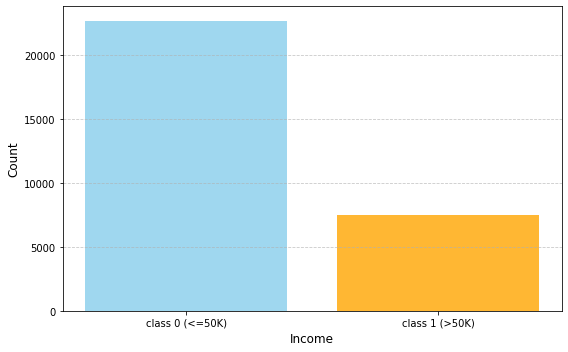

In [4]:
'''
check `income` distribution
'''

income_counts = {"0": data.income.value_counts()[0], "1": data.income.value_counts()[1]}

plot_class_imbalance(income_counts)

In [5]:
class_0 = data[data['income'] == 0].shape[0]
class_1 = data[data['income'] == 1].shape[0]
class_both = data['income'].shape[0]

pprint.pprint(f"the distribution of 0 and 1 are {class_0/class_both * 100:.2f}%, 1: {class_1/class_both * 100:.2f}%, respectively. this means that using the data in the current state will result in a model that is biased towards class 0. The modification/adjustment of model is required to address this issue.")

('the distribution of 0 and 1 are 75.11%, 1: 24.89%, respectively. this means '
 'that using the data in the current state will result in a model that is '
 'biased towards class 0. The modification/adjustment of model is required to '
 'address this issue.')


In [6]:
'''
split data
'''

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


## 3. Methods
![title](img/rfTree.png)
`(image source: https://upload.wikimedia.org/wikipedia/commons/4/4e/Random_forest_explain.png)`

In classification problem, the RF method works by constructing multiple decision trees during training and returns the majority vote from these trees.

### 3.1 baseline RF

- the gini impurity or entropy is defined as:
$$G_{\text{b}} = 1 - \sum_{i=1}^{C}p_{i}^{2}$$
where $C$ and $p_i$ denotes the number of class and proportion of samples in $i$ at the node.
- to make prediction on a new sample $x$, the algorithm (considering T trees) take a majority vote from the class probability $\hat{y}_{t}(x)$:
$$\hat{y} = \argmax_{i}{[\frac{1}{T}\sum_{t = 1}^{T}\hat{y}_{t}(x)_{i}]}, \quad \quad (...1)$$

- problem: baseline RF assumes equal importance for all classes, which may not work well for imbalanced datasets

### 3.2 weighted RF
 - this approach introduces class weights to modify the splitting criteria of the labels to prioritize minority class. We now introduce class weight to gini impurity as follow:
$$G_{\text{w}} = 1 - \sum_{i=1}^{C} w_{i}p_{i}^{2}$$
where $w_i$ denotes the class weight. To make prediction on a new sample $x$, this method uses `Eq.(1)` but with trees trained using weighted impurity.

### 3.3 Robust RF
- at each node, simulate small adversarial pertubations $\delta$ to sample $x$:
$$x_{p} = x + \delta, \quad ||\delta|| \le \epsilon$$
- we then compute the robust gini impurity:
$$G_{\text{p}} = 1 - \sum_{i=1}^{C} p_{i}(x_p)^{2}$$


## 4. Train models

In [7]:
'''
grids search on RF
'''

param_grid = {
    'class_weight': [{0: .6, 1: 2.1},{0: 1.0, 1: 1.5}, {0: 1.0, 1: 2.0}, {0: 0.5, 1: 2.5}],
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, scoring='roc_auc', cv=3)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_;best_params
print("Best parameters:", best_params)

Best parameters: {'class_weight': {0: 1.0, 1: 1.5}, 'max_depth': 10, 'n_estimators': 100}


paramter:
- in the weighted RF, changes to `class_weight` will modify the outcome of the model
- in the robust RF, changes to `epsilon` will modify the result 
- higher (lower) `n_estimator` could increase (reduce) model accuracy

In [8]:
'''
train model
'''

n_estimator = 50
seedS = 42

optimized_rf = RandomForestClassifier(
    class_weight=best_params['class_weight'],
    max_depth=best_params['max_depth'],
    n_estimators=best_params['n_estimators'],
    random_state=seedS
)

models = {
    "Baseline RF": RandomForestClassifier(n_estimators=n_estimator, random_state=seedS),
    "Weighted RF": optimized_rf,
    "Robust RF": RobustRandomForest(n_estimators=n_estimator, epsilon=0.1, random_state=seedS) #eps = 0.1
}

results = {}
for name, model in models.items():
    print(f"Training {name}")
    if isinstance(model, (RobustRandomForest)):
        model.fit(X_train, y_train, X_val, y_val)
    else:
        model.fit(X_train, y_train)

    # pred
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)
    y_pred_proba_test = model.predict_proba(X_test)[:, 1]

    # metric
    train_accuracy = accuracy_score(y_train, y_pred_train)
    val_accuracy = accuracy_score(y_val, y_pred_val)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    auc = roc_auc_score(y_test, y_pred_proba_test)

    print(classification_report(y_test, y_pred_test))

    results[name] = {
        "Train Accuracy": train_accuracy,
        "Val Accuracy": val_accuracy,
        "Test Accuracy": test_accuracy,
        "AUC": auc,
        "Model": model,
        }


Training Baseline RF
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      2262
           1       0.74      0.65      0.69       755

    accuracy                           0.85      3017
   macro avg       0.81      0.79      0.80      3017
weighted avg       0.85      0.85      0.85      3017

Training Weighted RF
              precision    recall  f1-score   support

           0       0.90      0.91      0.91      2262
           1       0.72      0.71      0.72       755

    accuracy                           0.86      3017
   macro avg       0.81      0.81      0.81      3017
weighted avg       0.86      0.86      0.86      3017

Training Robust RF
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      2262
           1       0.75      0.65      0.70       755

    accuracy                           0.86      3017
   macro avg       0.82      0.79      0.80      3017
weighted avg 

- baseline RF: the model's performance is slightly skewed toward the majority class. The overall accuracy and performance are balanced but influenced by the class imbalance.
- weight RF: adding class weight shows a better balance between classes
- robust RF: adding a small perturbations helps to prevent overfitting

## 5. metrics

In [9]:
'''
print results
'''

for name, metrics in results.items():
    print(f"{name}:")
    print(f"  Train Accuracy: {metrics['Train Accuracy']:.4f}")
    print(f"  Val Accuracy: {metrics['Val Accuracy']:.4f}")
    print(f"  Test Accuracy: {metrics['Test Accuracy']:.4f}")
    print(f"  AUC: {metrics['AUC']:.4f}")
    print()

Baseline RF:
  Train Accuracy: 0.9996
  Val Accuracy: 0.8544
  Test Accuracy: 0.8545
  AUC: 0.9005

Weighted RF:
  Train Accuracy: 0.8735
  Val Accuracy: 0.8664
  Test Accuracy: 0.8595
  AUC: 0.9160

Robust RF:
  Train Accuracy: 0.8857
  Val Accuracy: 0.8578
  Test Accuracy: 0.8575
  AUC: 0.9098



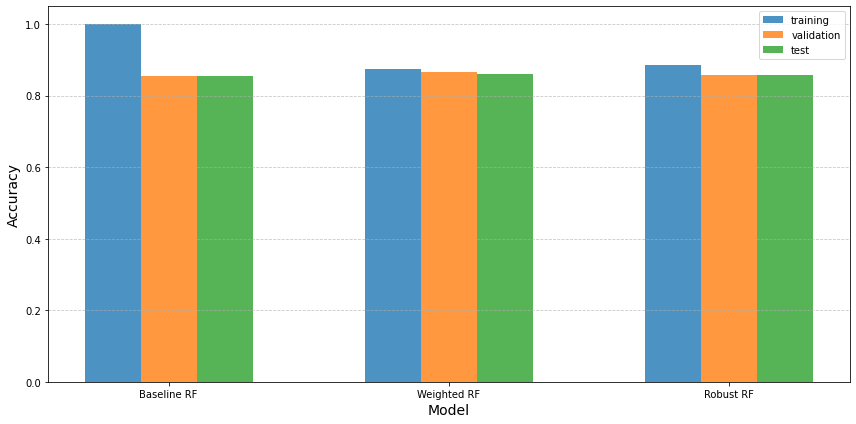

In [10]:
'''
plot accuraries
'''

labels = list(results.keys())
train_accuracies = [metrics['Train Accuracy'] for metrics in results.values()]
val_accuracies = [metrics['Val Accuracy'] for metrics in results.values()]
test_accuracies = [metrics['Test Accuracy'] for metrics in results.values()]

bar_width = 0.2
indices = np.arange(len(labels))

plot_barplot( indices, train_accuracies, val_accuracies, test_accuracies, labels, bar_width=bar_width, figsize=(12, 6))


First, the baseline RF slightly overfitting on the training accuracy compared to validation and test. second, the weighted RF improved minority class predictions, but at the cost of overall accuracy. and lastly, the introduction of noise or perturbation achieves better prediction and avoids overfitting.

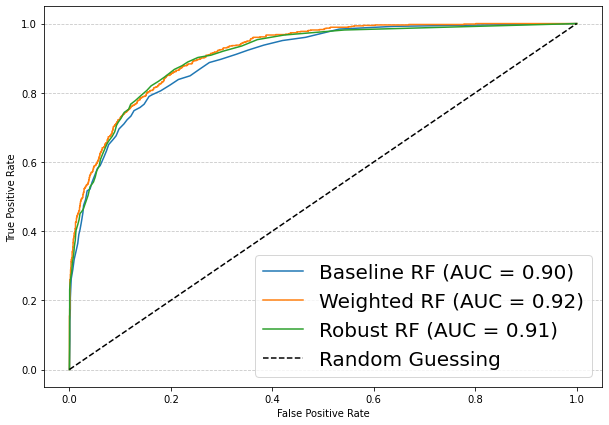

In [11]:
'''
plot AUC curves
'''

figsize=(10, 7)
plot_roc_curves(results, X_test, y_test, figsize=figsize, title=None)

The weighted RF achieved the highest AUC indicating this approach outperformed other two methods in distinguishing between positive and negative samples.

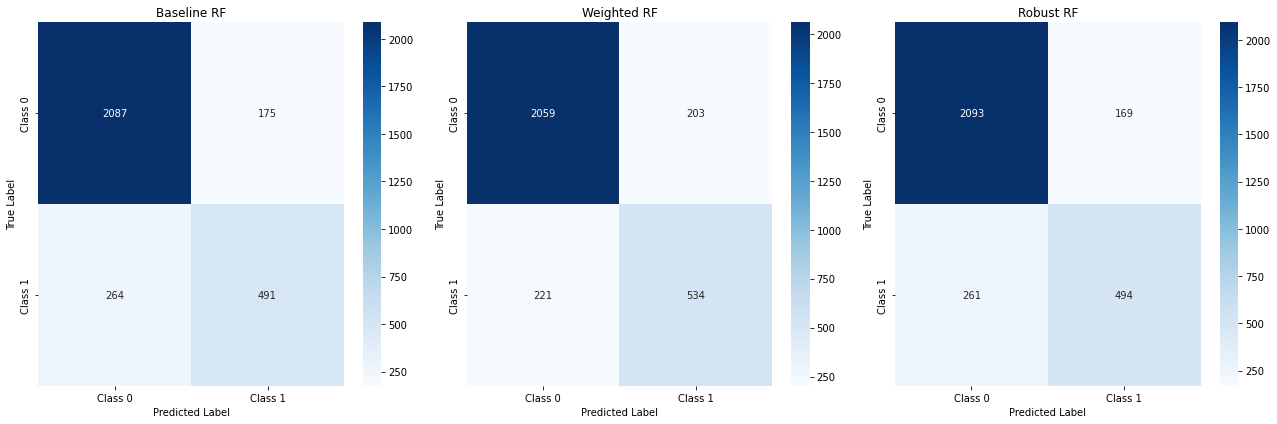

In [12]:
'''
plot confusion matrix
'''

plot_cm(results, X_test, y_test, figsize=(18, 6))

## 6. Conclusion
based on the metrics aboves, all the models achieve similar accuracy (~0.85–0.86), which indicates comparable overall performance. However, accuracy alone is insufficient for imbalanced datasets.
- the baseline RF method performs well overall, with high accuracy and AUC, but struggles with the minority class (low recall and F1-score). This is expected since it doesn't account for class imbalance.
- weighted RF improves the recall and F1-score for the minority class by prioritizing it during training. However, this comes at the cost of slightly reduced precision for the minority class and possibly some overfitting to the weighted data.
- robust RF achieves a balance by introducing noise, improving generalization and stability. Its performance is competitive across metrics, but it doesn't prioritize the minority class as effectively as weighted RF.

 ==============             END OF CODE         ======================